# Projet : Requêtez des services IA

## Objectif du projet

Ce projet a pour but d'exploiter un modèle de segmentation sémantique pré-entraîné via l'API Hugging Face.  
Le but est de détecter automatiquement les différentes classes d’objets présentes dans des images (ciel, route, personne, etc.) et de visualiser ces classes sous forme de masques colorisés.

---

## Chargement des bibliothèques et configuration

Importation des bibliothèques nécessaires (requests, PIL, matplotlib, etc.) et chargement des variables d’environnement via le fichier `.env`.

In [1]:
# Loading depandencies & env

import os
import io
import time
import base64
import requests
from PIL import Image
from dotenv import load_dotenv
from tqdm import tqdm
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

load_dotenv()
api_token = os.getenv("HF_TOKEN")
headers = {"Authorization": f"Bearer {api_token}"}

## Appel de l’API Hugging Face

Le modèle utilisé permet de segmenter les images selon plusieurs classes prédéfinies.  
L’API renvoie des masques encodés en base64 que nous décodons et convertissons en images binaires.

In [2]:
# API Call function

API_URL = "https://router.huggingface.co/hf-inference/models/mattmdjaga/segformer_b2_clothes"

def query_huggingface_api(image_path):
    image_buffer = preprocess_image(image_path)
    response = requests.post(API_URL, headers={"Content-Type": "image/jpeg", **headers}, data=image_buffer.read())
    
    if response.status_code != 200:
        raise Exception(f"Erreur API : {response.status_code}, {response.text}")
    
    return response.json()

## Prétraitement de l’image

Les images sont redimensionnées, converties en RGB et enregistrées temporairement en mémoire.  
Ce format est requis pour l'envoi à l'API Hugging Face afin de garantir un traitement rapide et compatible.

In [3]:
# Pre Process Iages Function

def preprocess_image(image_path, max_size=512):
    image = Image.open(image_path).convert("RGB")
    image.thumbnail((max_size, max_size))
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG")
    buffer.seek(0)
    return buffer

## Traitement des masques

Chaque segment est associé à une couleur spécifique (palette définie ou générée dynamiquement).  
Les masques sont superposés sur une image noire pour créer une visualisation finale.  
Une légende est automatiquement générée pour faciliter la lecture.

In [4]:
# Process & save Images

output_dir = "test-data/GMASK"
os.makedirs(output_dir, exist_ok=True)

# Define legend colors
CLASS_COLOR_MAP = {
    "sky": "#1f77b4",
    "floor": "#ff7f0e",
    "tree": "#2ca02c",
    "road": "#d62728",
    "person": "#9467bd",
    "earth": "#8c564b",
    "mountain": "#7f7f7f",
}

# Function to handle and save the masks from an image
def process_and_save_image(image_path, output_path):
    try:
        # Request to get the Masks from HF API response
        result = query_huggingface_api(image_path)
        image = Image.open(image_path).convert("RGB")
        image_np = np.array(image)
        mask_overlay = np.zeros_like(image_np)

        # Define colors
        colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
        np.random.seed(42)
        np.random.shuffle(colors)

        legend_elements = []

        for idx, segment in enumerate(result):
            if "mask" in segment:
                label = segment.get("label", f"Segment {idx+1}")

                # Set color by class (or hazard fallback)
                color_hex = CLASS_COLOR_MAP.get(label, colors[idx % len(colors)])
                rgb = np.array(mcolors.to_rgb(color_hex)) * 255
                rgb = rgb.astype(np.uint8)
        
                # Apply Mask
                mask_data = base64.b64decode(segment["mask"])
                mask_image = Image.open(io.BytesIO(mask_data)).convert("L")
                mask_np = np.array(mask_image.resize(image.size))
                mask_overlay[mask_np > 0] = rgb

                # Legend item
                patch = mpatches.Patch(color=color_hex, label=label)
                legend_elements.append(patch)


        # Save mask image with legend
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(mask_overlay)
        ax.axis("off")
        ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        fig.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
        plt.close()

    except Exception as e:
        print(f"Erreur avec l'image {image_path} : {e}")

## Affichage des résultats

Nous affichons ici 3 exemples comparant les images originales et les masques générés.  
Cela permet de vérifier la qualité de la segmentation et la cohérence des classes détectées.

Traitement des images:   0%|                                                                    | 0/50 [00:04<?, ?it/s]


⏱️ Temps total : 4.88 sec pour 50 images
⏱️ Temps moyen par image : 0.10 sec


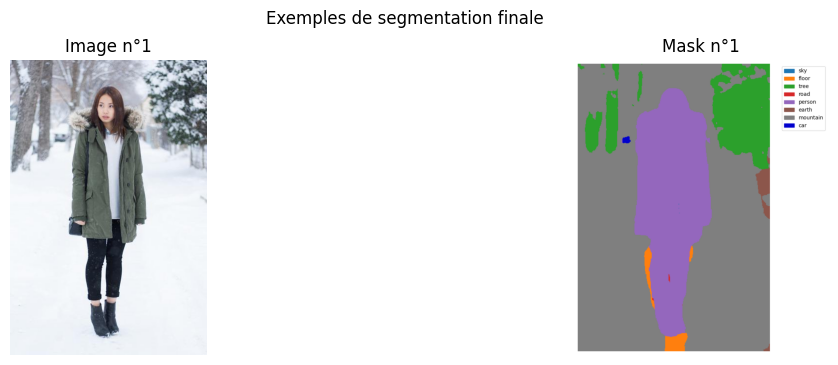

In [5]:
# Code execution

input_dir = "test-data/IMG"
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
start = time.time()

for image_file in tqdm(image_files, desc="Traitement des images"):
    image_path = os.path.join(input_dir, image_file)
    output_path = os.path.join(output_dir, image_file)
    process_and_save_image(image_path, output_path)

end = time.time()
total_time = end - start
avg_time = total_time / len(image_files)

print(f"⏱️ Temps total : {total_time:.2f} sec pour {len(image_files)} images")
print(f"⏱️ Temps moyen par image : {avg_time:.2f} sec")

# Display 3 comparaison examples
mask_dir = "test-data/GMASK"
mask_images_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
example_images = mask_images_files[:3]

plt.figure(figsize=(12, 10))

for i, img_name in enumerate(example_images):
    # Display of the og mmg
    og_img_path = os.path.join(input_dir, f"image_{i}.png")
    og_img = Image.open(og_img_path)
    plt.subplot(3, 2, i * 2 + 1)
    plt.imshow(og_img)
    plt.title(f"Image n°{i+1}")
    plt.axis("off")
    
    # Display of the mask img
    img_path = os.path.join(mask_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(3, 2, i * 2 + 2)
    plt.imshow(img)
    plt.title(f"Mask n°{i+1}")
    plt.axis("off")

plt.suptitle("Exemples de segmentation finale")
plt.tight_layout()
plt.show()

## Analyse des résultats

Le modèle parvient à identifier correctement les classes les plus fréquentes.

Des erreurs peuvent apparaître sur des éléments plus petits ou moins visibles.

L’usage d’un modèle plus puissant pourrait améliorer la précision dans certains contextes (éléments trop petits ou pas entièrement visible).

## Conclusion

Ce projet m’a permis de :
- me familiariser avec les appels d’API d’un modèle IA,
- manipuler et afficher des images segmentées en Python,
- automatiser un traitement d’images en batch,
- analyser visuellement des résultats.